In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Compare NIBIO background coefficients to TEOTIL3

Marianne has sent a presentation containing background coefficients used by the agricultural models (see e-mail received 21.08.2023 at 16.16). I think these coefficients represent expected background fluxes from agricultural areas *if they were natural* (i.e. no agriculture). Since these coefficients have been estimated independently, it is interesting to compare them with the new values from TEOTIL3.

## 1. Convert TEOTIL coefficients

From concentrations to kg/da/yr, assuming long-term average runoff (1990 - 2021).

In [2]:
reg_year = 2022
coeff_csv = r"../../data/spatially_variable_background_coefficients.csv"

In [3]:
# Read regines
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{reg_year}"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_csv = os.path.join(data_fold, "tidied", f"regine_{reg_year}.csv")
reg_gdf = gpd.read_file(teo_gpkg, layer=f"regine_{reg_year}", driver="GPKG")
reg_gdf = reg_gdf[["regine", "runoff_mm/yr", "geometry"]]

# Background coeffs
coef_df = pd.read_csv(coeff_csv)
coef_df = coef_df[["regine", "wood_totn_µg/l", "wood_totp_µg/l"]]

# Join
gdf = reg_gdf.merge(coef_df, how="left", on="regine")
gdf.head()

,regine,runoff_mm/yr,geometry,wood_totn_µg/l,wood_totp_µg/l
0,001.10,602,"MULTIPOLYGON (((297006.830 6543966.950, 297169...",498.8,8.4
1,001.1A1,620,"MULTIPOLYGON (((297505.440 6543157.790, 297543...",500.6,8.4
2,001.1A20,594,"MULTIPOLYGON (((297770.368 6543429.036, 297787...",500.7,8.4
3,001.1A2A,637,"MULTIPOLYGON (((299678.370 6544460.320, 299667...",504.4,8.5
4,001.1A2B,637,"MULTIPOLYGON (((303353.460 6552989.330, 303341...",500.9,8.5


In [4]:
# Check for NaN
pd.isna(gdf).sum(axis="rows")

regine            0
runoff_mm/yr      0
geometry          0
wood_totn_µg/l    0
wood_totp_µg/l    0
dtype: int64

In [5]:
# Convert units
gdf["wood_totn_kg/da/yr"] = 1000 * gdf["runoff_mm/yr"] * gdf["wood_totn_µg/l"] / 1e9
gdf["wood_totp_g/da/yr"] = 1000 * gdf["runoff_mm/yr"] * gdf["wood_totp_µg/l"] / 1e6
gdf = gdf.query("`runoff_mm/yr` > 0")
gdf.describe(percentiles=[.01, .25, .5, .75, .99])

,runoff_mm/yr,wood_totn_µg/l,wood_totp_µg/l,wood_totn_kg/da/yr,wood_totp_g/da/yr
count,23664.000000,23664.000000,23664.000000,23664.000000,23664.000000
mean,1561.730646,207.976403,3.777117,0.303351,5.180971
std,945.178346,64.471793,1.288602,0.172929,2.484005
min,158.000000,104.800000,2.100000,0.027808,0.616200
1%,327.000000,106.800000,2.100000,0.057701,1.384315
25%,761.000000,167.500000,2.800000,0.162985,3.143900
50%,1387.000000,191.500000,3.500000,0.260939,4.851350
75%,2144.000000,239.025000,4.400000,0.418595,6.776775
99%,4134.370000,421.437000,8.237000,0.757057,12.042847
max,5650.000000,536.800000,9.400000,1.025270,16.552800


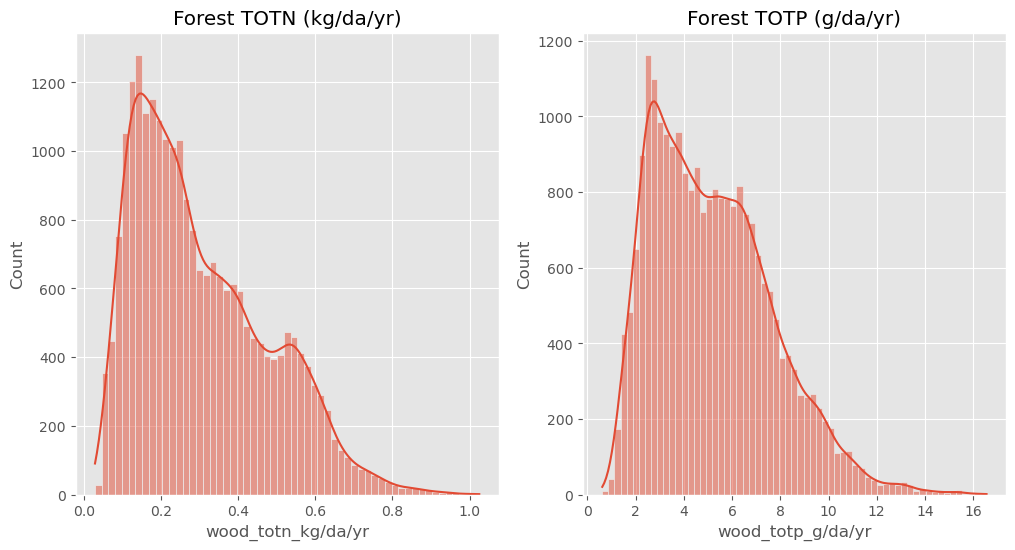

In [6]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sn.histplot(data=gdf["wood_totn_kg/da/yr"], kde=True, ax=axes[0])
sn.histplot(data=gdf["wood_totp_g/da/yr"], kde=True, ax=axes[1])
axes[0].set_title("Forest TOTN (kg/da/yr)")
axes[1].set_title("Forest TOTP (g/da/yr)");